<a href="https://colab.research.google.com/github/vbvss199/colab_notebooks/blob/main/finale_testing_under_2023fall_hyperparmeter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing all the necessary libraries
import torch
import torch.nn as nn
import torch.functional as F
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
from torch.utils.data import DataLoader,TensorDataset, random_split, WeightedRandomSampler
import torch.optim as optim
from torchsummary import summary

In [ ]:
data=pd.read_excel('pre-processed-data_college_code.xlsx')

In [ ]:
data.columns

Index(['Application Major', 'Scholarship_Awarded', 'Application CGPA',
       'FAFSA Filed', 'High School Code', 'Financial Aid Appeal',
       'Accepted Student Day Event Attended', 'Campus Visits - Person',
       'Campus Visits - App', 'Logins Before Admit', 'Acceptance Call Success',
       'Application Consider Test Scores', 'Application ACRK',
       'Waitlist Confirmed Date', 'Emails Sent', 'Emails Opened',
       'Was Inquiry', 'Athlete', 'admitted', 'Address 1 Region_Midwest',
       'Address 1 Region_Military', 'Address 1 Region_Northeast',
       'Address 1 Region_South', 'Address 1 Region_Southwest',
       'Address 1 Region_Territory', 'Address 1 Region_West',
       'Application Housing_Commuter', 'Application Housing_Residential',
       'Application Enroll Status_Full Time',
       'Application Enroll Status_Part Time', 'Person Sex_F', 'Person Sex_M',
       'Person Sex_Unknown', 'High School Region_Midwest',
       'High School Region_Military', 'High School Region_Nor

In [ ]:
inputs=data.drop(['admitted'],axis=1).to_numpy()
labels=data['admitted'].to_numpy()

In [ ]:
inputs.shape[1]

48

In [ ]:
input_embedding_dimension=len(set(inputs[:,0]))
input_embedding_dimension

102

In [ ]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    inputs, labels, test_size=0.2, random_state=42, stratify=labels
)
# Convert to PyTorch tensors only once
train_inputs = torch.from_numpy(train_inputs).float()
test_inputs = torch.from_numpy(test_inputs).float()
train_labels = torch.from_numpy(train_labels).int()
test_labels = torch.from_numpy(test_labels).int()

In [ ]:
#The TensorDataset class in PyTorch is a utility class that is used to wrap data tensors (such as features and labels)
#This class is particularly useful when you want to work with datasets where features and labels are already stored as tensors.
train_dataset = TensorDataset(train_inputs, train_labels)
test_dataset = TensorDataset(test_inputs, test_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
print("Checking train_inputs for NaN:", torch.any(torch.isnan(train_inputs)))
print("Checking train_inputs for Inf:", torch.any(torch.isinf(train_inputs)))
print("Checking train_labels for NaN:", torch.any(torch.isnan(train_labels)))
print("Checking train_labels for Inf:", torch.any(torch.isinf(train_labels)))

Checking train_inputs for NaN: tensor(False)
Checking train_inputs for Inf: tensor(False)
Checking train_labels for NaN: tensor(False)
Checking train_labels for Inf: tensor(False)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

class NeuralNetwork(nn.Module):
    def __init__(self, i, h_size, h_next_size, h_next_next_size=19, n_classes=2,
                 how_many_layers=4, embedding_dim=12,hs_embedding_dim=50):
        super(NeuralNetwork, self).__init__()

        features = i.shape[1]  # Total number of input features

        self.major_embedding = nn.Embedding(input_embedding_dimension, embedding_dim)

        #embedding layer for the high school codes
        self.hs_embedding=nn.Embedding(len(set(inputs[:,4])),hs_embedding_dim)

        # Input to fc1 will be (features - 2) continuous + embedding_dim
        self.fc1 = nn.Linear(features - 2 + embedding_dim + hs_embedding_dim, h_size)
        self.layers = how_many_layers

        if self.layers == 2:
            self.fc2 = nn.Linear(h_size, n_classes)
        elif self.layers == 3:
            self.fc3 = nn.Linear(h_size, h_next_size)
            self.fc4 = nn.Linear(h_next_size, n_classes)
        elif self.layers == 4:
            self.fc3 = nn.Linear(h_size, h_next_size)
            self.fc4 = nn.Linear(h_next_size, h_next_next_size)
            self.fc5 = nn.Linear(h_next_next_size, n_classes)

    def forward(self, X):
        # Ensure input is float and extract categorical/continuous features
        categorical_input = X[:, 0].long()  # First column: categorical (encoded)
        hs_input = X[:, 4].long()

        #continuous_input = X[:, 1:].float() # Rest: continuous features
        continuous_indices = [i for i in range(X.shape[1]) if i not in [0, 4]]
        continuous_input = X[:, continuous_indices].float()

        # Apply embedding
        embedded = self.major_embedding(categorical_input)  # Shape: [batch_size, embedding_dim]
        hs_embedded = self.hs_embedding(hs_input)

        # Concatenate with continuous features
        X = torch.cat((embedded,hs_embedded, continuous_input), dim=1)  # Shape: [batch_size, embedding_dim + (features-1)]

        if self.layers == 2:
            X = F.relu(self.fc1(X))
            X = self.fc2(X)
        elif self.layers == 3:
            X = F.relu(self.fc1(X))
            X = F.relu(self.fc3(X))
            X = self.fc4(X)
        elif self.layers == 4:
            X = F.relu(self.fc1(X))
            X = torch.tanh(self.fc3(X))
            X = F.sigmoid(self.fc4(X))
            X = self.fc5(X)

        return X


net = NeuralNetwork(inputs, h_size=27, h_next_size=22, how_many_layers=4)
print(f"Expected input features to fc1: {train_inputs.shape[1] - 1 + 8}")  # Debug print
print(f"fc1 weight shape: {net.fc1.weight.shape}")  # Debug printn_epochs = 600


n_epochs = 600
learning_rate = 0.001
decay_rate = learning_rate / n_epochs
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=decay_rate)
lambda_reg = 0.01
lambda_entropy = 0


def loss_fn(model, outputs, targets):
    # Convert labels to numpy
    y_train = train_labels.numpy()

    # Compute class weights
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)

    # Convert to PyTorch tensor
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

    cross_entropy = nn.functional.cross_entropy(outputs, targets,weight=class_weights_tensor)
    l2_regularization = 0
    entropy_regularization = 0

    for param in model.parameters():
        l2_regularization += torch.norm(param, p=2) ** 2
        entropy_regularization += torch.mean(torch.sum(-outputs * torch.log(outputs), dim=1))

    loss = cross_entropy + lambda_reg * l2_regularization
    return loss

def test_instance(model):
    y_t = []
    y_s = []
    loss = 0
    acc = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss += loss_fn(model, outputs, labels.long())
            y_t.extend(labels.numpy().astype('int'))
            y_s.extend(torch.sigmoid(outputs).max(axis=1).indices.numpy())

    acc = accuracy_score(y_t, y_s)
    return loss, acc

iteration = 0
counter = 0

for epoch in range(n_epochs):
    running_loss = 0.0
    total = 0  # No. of total predictions
    correct = 0  # No. of correct predictions

    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = loss_fn(net, outputs, labels.long())
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(train_loader.dataset)  # Loss in every epoch
    epoch_acc = correct / total  # Accuracy for every epoch

    if epoch % 10 == 0 or epoch == n_epochs - 1:
        print(f'Epoch: {epoch + 1}/{n_epochs} | pLoss: {running_loss / len(inputs)} | Accuracy: {epoch_acc} | Loss: {epoch_loss}')

    if epoch % 50 == 0:
        test_loss, test_acc = test_instance(net)
        print(f'Epoch: {epoch + 1} | The test data Accuracy = {test_acc} | Test Loss = {test_loss}')

        if counter < test_acc:
            save_net = net
            counter = test_acc

y_true = []
y_scores = []
test_loss = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = save_net(inputs)
        test_loss += loss_fn(net, outputs, labels.long())
        y_true.extend(labels.numpy().astype('int'))
        y_scores.extend(torch.sigmoid(outputs).max(axis=1).indices.numpy())


accuracy = accuracy_score(y_true, y_scores)
precision = precision_score(y_true, y_scores)
recall = recall_score(y_true, y_scores)
f1_val = f1_score(y_true, y_scores)
auc_roc = roc_auc_score(y_true, y_scores)

print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F1 Score: {:.4f}'.format(f1_val))
print('AUROC Score: {:.4f}'.format(auc_roc))


Expected input features to fc1: 55
fc1 weight shape: torch.Size([27, 108])
Epoch: 1/600 | pLoss: 730366.5755615234 | Accuracy: 0.8536078186733208 | Loss: 1366.8744396035997
Epoch: 1 | The test data Accuracy = 0.9372141372141373 | Test Loss = 45932.42578125
Epoch: 11/600 | pLoss: 69178.78113047282 | Accuracy: 0.9481181118735704 | Loss: 129.46746312627477
Epoch: 21/600 | pLoss: 4954.694371541341 | Accuracy: 0.9508213765855688 | Loss: 9.27266569845541
Epoch: 31/600 | pLoss: 304.9963841040929 | Accuracy: 0.9510293200249532 | Loss: 0.5707979739939356
Epoch: 41/600 | pLoss: 122.04463728931215 | Accuracy: 0.9508213765855688 | Loss: 0.2284054347273465
Epoch: 51/600 | pLoss: 118.85160420007176 | Accuracy: 0.9494697442295695 | Loss: 0.2224297021835404
Epoch: 51 | The test data Accuracy = 0.9530145530145531 | Test Loss = 8.170372009277344
Epoch: 61/600 | pLoss: 118.9663270107574 | Accuracy: 0.9541484716157205 | Loss: 0.22264440488600884
Epoch: 71/600 | pLoss: 117.51368462045987 | Accuracy: 0.9515

Confusion Matrix:
 [[1990  122]
 [   7  286]]


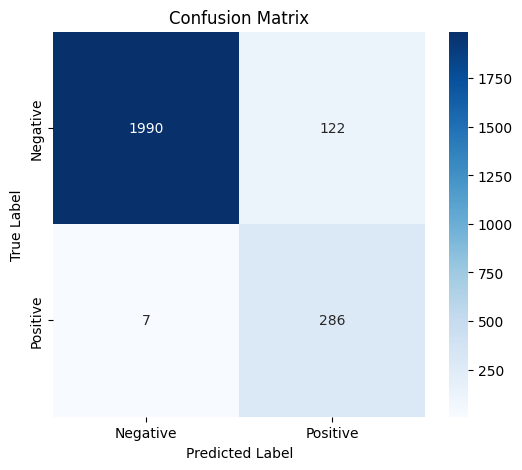

True Positives (TP): 286
False Positives (FP): 122
True Negatives (TN): 1990
False Negatives (FN): 7


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_scores)

# Print the matrix
print("Confusion Matrix:\n", cm)

# Plot the Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

from sklearn.metrics import confusion_matrix

# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_scores)

# Extract TP, TN, FP, FN
TN = cm[0, 0]  # True Negative
FP = cm[0, 1]  # False Positive
FN = cm[1, 0]  # False Negative
TP = cm[1, 1]  # True Positive

print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")


In [ ]:
data_2023=pd.read_excel('/content/processed_fall_2023.xlsx')
# Ensure that new_data has the same columns as the training data except for the target column
print(data_2023.columns)
new_data = data_2023[data_2023.drop(['admitted'], axis=1).columns]
print(new_data.shape[1])
data_2023_labels=data_2023['admitted'].to_numpy()

# Make sure new_data is a PyTorch tensor
new_data_tensor = torch.from_numpy(new_data.to_numpy()).float()

# Perform inference on the new data
with torch.no_grad():
    # Assuming your model is saved in 'save_net' after training
    outputs = save_net(new_data_tensor)

# Get predicted class labels from the outputs
predictions = torch.argmax(outputs, dim=1)

# If you want the predicted probabilities, you can use:
# probabilities = torch.softmax(outputs, dim=1)

# Convert predictions to numpy for further processing
predictions = predictions.numpy()

print("Predictions on new data:")
print(predictions)
print(len(predictions))


accuracy = accuracy_score(data_2023_labels,predictions)
precision = precision_score(data_2023_labels,predictions)
recall = recall_score(data_2023_labels, predictions)
f1_val = f1_score(data_2023_labels, predictions)
auc_roc = roc_auc_score(data_2023_labels, predictions)

print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F1 Score: {:.4f}'.format(f1_val))
print('AUROC Score: {:.4f}'.format(auc_roc))







Index(['Application Major', 'Scholarship_Awarded', 'Application CGPA',
       'FAFSA Filed', 'High School Code', 'Financial Aid Appeal',
       'Accepted Student Day Event Attended', 'Campus Visits - Person',
       'Campus Visits - App', 'Logins Before Admit', 'Acceptance Call Success',
       'Application Consider Test Scores', 'Application ACRK',
       'Waitlist Confirmed Date', 'Emails Sent', 'Emails Opened',
       'Was Inquiry', 'Athlete', 'admitted', 'Address 1 Region_Midwest',
       'Address 1 Region_Northeast', 'Address 1 Region_South',
       'Address 1 Region_Southwest', 'Address 1 Region_Territory',
       'Address 1 Region_West', 'Application Housing_Commuter',
       'Application Housing_Residential',
       'Application Enroll Status_Full Time',
       'Application Enroll Status_Part Time', 'Person Sex_F', 'Person Sex_M',
       'High School Region_Midwest', 'High School Region_Northeast',
       'High School Region_South', 'High School Region_Southwest',
       'High 

In [ ]:
data_2023_labels=data_2023['admitted'].to_numpy()
data_2023_labels

array([1, 0, 0, ..., 0, 0, 1])

Confusion Matrix:
 [[7900  525]
 [ 171 1238]]


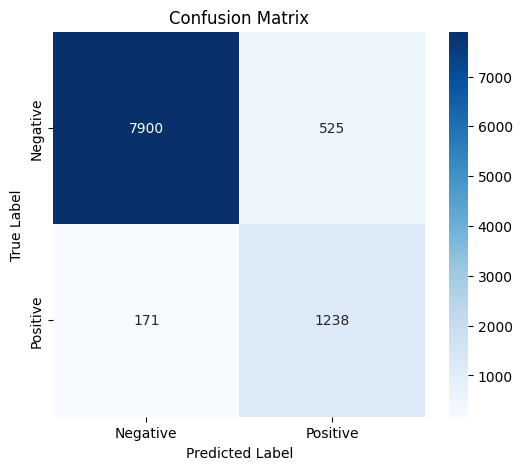

True Positives (TP): 1238
False Positives (FP): 525
True Negatives (TN): 7900
False Negatives (FN): 171


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute Confusion Matrix
cm = confusion_matrix(data_2023_labels,predictions)

# Print the matrix
print("Confusion Matrix:\n", cm)

# Plot the Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

from sklearn.metrics import confusion_matrix

# Compute Confusion Matrix
cm = confusion_matrix(data_2023_labels,predictions)

# Extract TP, TN, FP, FN
TN = cm[0, 0]  # True Negative
FP = cm[0, 1]  # False Positive
FN = cm[1, 0]  # False Negative
TP = cm[1, 1]  # True Positive

print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")


## hyper parameter tuning


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import random

class NeuralNetwork(nn.Module):
    def __init__(self, i, num_major_categories, num_hs_codes, h_size, h_next_size,
                 h_next_next_size=19, n_classes=2, how_many_layers=4, embedding_dim=12,
                 hs_embedding_dim=50):
        super(NeuralNetwork, self).__init__()

        features = i.shape[1]
        print(f"Embedding sizes - Major: {num_major_categories}, HS: {num_hs_codes}")

        self.major_embedding = nn.Embedding(num_major_categories, embedding_dim)
        self.hs_embedding = nn.Embedding(num_hs_codes, hs_embedding_dim)

        self.fc1 = nn.Linear(features - 2 + embedding_dim + hs_embedding_dim, h_size)
        self.layers = how_many_layers

        if self.layers == 2:
            self.fc2 = nn.Linear(h_size, n_classes)
        elif self.layers == 3:
            self.fc3 = nn.Linear(h_size, h_next_size)
            self.fc4 = nn.Linear(h_next_size, n_classes)
        elif self.layers == 4:
            self.fc3 = nn.Linear(h_size, h_next_size)
            self.fc4 = nn.Linear(h_next_size, h_next_next_size)
            self.fc5 = nn.Linear(h_next_next_size, n_classes)

    def forward(self, X):
        categorical_input = X[:, 0].long()
        hs_input = X[:, 4].long()

        if categorical_input.max() >= self.major_embedding.num_embeddings:
            raise ValueError(f"categorical_input max ({categorical_input.max()}) exceeds major_embedding size ({self.major_embedding.num_embeddings})")
        if hs_input.max() >= self.hs_embedding.num_embeddings:
            raise ValueError(f"hs_input max ({hs_input.max()}) exceeds hs_embedding size ({self.hs_embedding.num_embeddings})")

        continuous_indices = [idx for idx in range(X.shape[1]) if idx not in [0, 4]]
        continuous_input = X[:, continuous_indices].float()

        embedded = self.major_embedding(categorical_input)
        hs_embedded = self.hs_embedding(hs_input)
        X = torch.cat((embedded, hs_embedded, continuous_input), dim=1)

        if self.layers == 2:
            X = F.relu(self.fc1(X))
            X = self.fc2(X)
        elif self.layers == 3:
            X = F.relu(self.fc1(X))
            X = F.relu(self.fc3(X))
            X = self.fc4(X)
        elif self.layers == 4:
            X = F.relu(self.fc1(X))
            X = torch.tanh(self.fc3(X))
            X = F.sigmoid(self.fc4(X))
            X = self.fc5(X)

        return X

# Loss function
def loss_fn(model, outputs, targets):
    y_train = train_labels.numpy()
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

    cross_entropy = nn.functional.cross_entropy(outputs, targets, weight=class_weights_tensor)
    l2_regularization = sum(torch.norm(param, p=2) ** 2 for param in model.parameters())
    loss = cross_entropy + lambda_reg * l2_regularization
    return loss

# Test function
def test_instance(model, test_loader):
    y_t, y_s = [], []
    loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss += loss_fn(model, outputs, labels.long())
            y_t.extend(labels.numpy().astype('int'))
            y_s.extend(torch.sigmoid(outputs).max(axis=1).indices.numpy())
    acc = accuracy_score(y_t, y_s)
    return loss, acc

# Hyperparameter search function with epoch printing
def train_and_evaluate(params, train_inputs, num_major_categories, num_hs_codes, train_loader, test_loader):
    global lambda_reg
    lambda_reg = params['lambda_reg']

    net = NeuralNetwork(train_inputs, num_major_categories, num_hs_codes,
                        h_size=params['h_size'],
                        h_next_size=params['h_next_size'],
                        h_next_next_size=params['h_next_next_size'],
                        how_many_layers=params['how_many_layers'],
                        embedding_dim=params['embedding_dim'],
                        hs_embedding_dim=params['hs_embedding_dim'])

    optimizer = optim.Adam(net.parameters(), lr=params['learning_rate'], weight_decay=params['learning_rate'] / params['n_epochs'])

    # Training loop with epoch logging
    for epoch in range(params['n_epochs']):
        running_loss = 0.0
        total = 0
        correct = 0

        for inputs_batch, labels in train_loader:
            optimizer.zero_grad()
            outputs = net(inputs_batch)
            loss = loss_fn(net, outputs, labels.long())
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs_batch.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total

        # Print every 10 epochs or at the end
        if epoch % 10 == 0 or epoch == params['n_epochs'] - 1:
            print(f'Epoch: {epoch + 1}/{params["n_epochs"]} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}')

        # Optionally evaluate on test set every 50 epochs
        if epoch % 50 == 0:
            test_loss, test_acc = test_instance(net, test_loader)
            print(f'Epoch: {epoch + 1} | Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}')

    # Final test evaluation
    test_loss, test_acc = test_instance(net, test_loader)
    print(f'Final Test Loss: {test_loss:.4f} | Final Test Accuracy: {test_acc:.4f}')

    y_true, y_scores = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = net(inputs)
            y_true.extend(labels.numpy().astype('int'))
            y_scores.extend(torch.sigmoid(outputs).max(axis=1).indices.numpy())

    f1 = f1_score(y_true, y_scores)
    return f1, net

# Data preparation
inputs = data.drop(['admitted'], axis=1).to_numpy()
labels = data['admitted'].to_numpy()

# Calculate embedding sizes based on full dataset
num_major_categories = len(set(inputs[:, 0]))
num_hs_codes = len(set(inputs[:, 4]))
print(f"Full dataset - Major categories: {num_major_categories}, HS codes: {num_hs_codes}")

# Split into train and test sets
train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    inputs, labels, test_size=0.2, random_state=42, stratify=labels
)

# Convert to PyTorch tensors
train_inputs = torch.from_numpy(train_inputs)
test_inputs = torch.from_numpy(test_inputs)
train_labels = torch.from_numpy(train_labels).int()
test_labels = torch.from_numpy(test_labels).int()

# Create data loaders
train_dataset = TensorDataset(train_inputs, train_labels)
test_dataset = TensorDataset(test_inputs, test_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Hyperparameter ranges
param_space = {
    'h_size': [16, 27, 32, 64],
    'h_next_size': [16, 22, 32, 48],
    'h_next_next_size': [16, 19, 24, 32],
    'how_many_layers': [2, 3, 4],
    'learning_rate': [0.0001, 0.001, 0.01],
    'n_epochs': [200, 400, 600],
    'lambda_reg': [0.001, 0.01, 0.1],
    'embedding_dim': [8, 12, 16],
    'hs_embedding_dim': [32, 50, 64]
}

# Random search
n_trials = 20
best_f1 = -1
best_params = None
best_model = None

for _ in range(n_trials):
    params = {key: random.choice(values) for key, values in param_space.items()}
    print(f"\nTrying params: {params}")
    f1, model = train_and_evaluate(params, train_inputs, num_major_categories, num_hs_codes, train_loader, test_loader)
    print(f"F1 Score: {f1}")

    if f1 > best_f1:
        best_f1 = f1
        best_params = params
        best_model = model

print("\nBest Parameters:", best_params)
print("Best F1 Score:", best_f1)

# Final evaluation
y_true, y_scores = [], []
test_loss = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = best_model(inputs)
        test_loss += loss_fn(best_model, outputs, labels.long())
        y_true.extend(labels.numpy().astype('int'))
        y_scores.extend(torch.sigmoid(outputs).max(axis=1).indices.numpy())

accuracy = accuracy_score(y_true, y_scores)
precision = precision_score(y_true, y_scores)
recall = recall_score(y_true, y_scores)
f1_val = f1_score(y_true, y_scores)
auc_roc = roc_auc_score(y_true, y_scores)

print('Final Results with Best Parameters:')
print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F1 Score: {:.4f}'.format(f1_val))
print('AUROC Score: {:.4f}'.format(auc_roc))

Full dataset - Major categories: 102, HS codes: 3032

Trying params: {'h_size': 16, 'h_next_size': 22, 'h_next_next_size': 16, 'how_many_layers': 4, 'learning_rate': 0.01, 'n_epochs': 200, 'lambda_reg': 0.01, 'embedding_dim': 8, 'hs_embedding_dim': 50}
Embedding sizes - Major: 102, HS: 3032
Epoch: 1/200 | Loss: 577.2399 | Accuracy: 0.9141
Epoch: 1 | Test Loss: 5242.2539 | Test Accuracy: 0.9613
Epoch: 11/200 | Loss: 0.2492 | Accuracy: 0.9406
Epoch: 21/200 | Loss: 0.2551 | Accuracy: 0.9346
Epoch: 31/200 | Loss: 0.2550 | Accuracy: 0.9363
Epoch: 41/200 | Loss: 0.2531 | Accuracy: 0.9372
Epoch: 51/200 | Loss: 0.2453 | Accuracy: 0.9387
Epoch: 51 | Test Loss: 9.0006 | Test Accuracy: 0.9210
Epoch: 61/200 | Loss: 0.2454 | Accuracy: 0.9423
Epoch: 71/200 | Loss: 0.2683 | Accuracy: 0.9318
Epoch: 81/200 | Loss: 0.2485 | Accuracy: 0.9408
Epoch: 91/200 | Loss: 0.2839 | Accuracy: 0.9365
Epoch: 101/200 | Loss: 0.2451 | Accuracy: 0.9426
Epoch: 101 | Test Loss: 9.0295 | Test Accuracy: 0.9272
Epoch: 111/20

In [ ]:
best_model

NeuralNetwork(
  (major_embedding): Embedding(102, 16)
  (hs_embedding): Embedding(3032, 50)
  (fc1): Linear(in_features=112, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=48, bias=True)
  (fc4): Linear(in_features=48, out_features=2, bias=True)
)

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, i, h_size, h_next_size, h_next_next_size=32, n_classes=2,
                 how_many_layers=4, embedding_dim=12,hs_embedding_dim=50):
        super(NeuralNetwork, self).__init__()

        features = i.shape[1]  # Total number of input features

        self.major_embedding = nn.Embedding(input_embedding_dimension, embedding_dim)

        #embedding layer for the high school codes
        self.hs_embedding=nn.Embedding(len(set(inputs[:,4])),hs_embedding_dim)

        # Input to fc1 will be (features - 2) continuous + embedding_dim
        self.fc1 = nn.Linear(features - 2 + embedding_dim + hs_embedding_dim, h_size)
        self.layers = how_many_layers

        if self.layers == 2:
            self.fc2 = nn.Linear(h_size, n_classes)
        elif self.layers == 3:
            self.fc3 = nn.Linear(h_size, h_next_size)
            self.fc4 = nn.Linear(h_next_size, n_classes)
        elif self.layers == 4:
            self.fc3 = nn.Linear(h_size, h_next_size)
            self.fc4 = nn.Linear(h_next_size, h_next_next_size)
            self.fc5 = nn.Linear(h_next_next_size, n_classes)

    def forward(self, X):
        # Ensure input is float and extract categorical/continuous features
        categorical_input = X[:, 0].long()  # First column: categorical (encoded)
        hs_input = X[:, 4].long()

        #continuous_input = X[:, 1:].float() # Rest: continuous features
        continuous_indices = [i for i in range(X.shape[1]) if i not in [0, 4]]
        continuous_input = X[:, continuous_indices].float()

        # Apply embedding
        embedded = self.major_embedding(categorical_input)  # Shape: [batch_size, embedding_dim]
        hs_embedded = self.hs_embedding(hs_input)

        # Concatenate with continuous features
        X = torch.cat((embedded,hs_embedded, continuous_input), dim=1)  # Shape: [batch_size, embedding_dim + (features-1)]

        if self.layers == 2:
            X = F.relu(self.fc1(X))
            X = self.fc2(X)
        elif self.layers == 3:
            X = F.relu(self.fc1(X))
            X = F.relu(self.fc3(X))
            X = self.fc4(X)
        elif self.layers == 4:
            X = F.relu(self.fc1(X))
            X = torch.tanh(self.fc3(X))
            X = F.sigmoid(self.fc4(X))
            X = self.fc5(X)

        return X


In [ ]:
import pandas as pd
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


data_2023 = pd.read_excel('/content/processed_fall_2025_030325.xlsx')
# Ensure that new_data has the same columns as the training data except for the target column
print(data_2023.columns)
new_data = data_2023[data_2023.drop(['admitted'], axis=1).columns]
print(new_data.shape[1])
data_2023_labels = data_2023['admitted'].to_numpy()

# Make sure new_data is a PyTorch tensor
new_data_tensor = torch.from_numpy(new_data.to_numpy()).float()
save_net = torch.load('/content/save_net_fall.pth')

# Get the number of categories for the 'Application Major' feature from the trained model
num_major_categories = save_net.major_embedding.num_embeddings

# ----> Clip categorical input values to be within the valid range
new_data_tensor[:, 0] = torch.clamp(new_data_tensor[:, 0], 0, num_major_categories - 1)
# <----
# Perform inference on the new data
with torch.no_grad():
    # Assuming your model is saved in 'save_net' after training
    outputs = save_net(new_data_tensor)

# Get predicted class labels from the outputs
predictions = torch.argmax(outputs, dim=1)

# If you want the predicted probabilities, you can use:
# probabilities = torch.softmax(outputs, dim=1)

# Convert predictions to numpy for further processing
predictions = predictions.numpy()

print("Predictions on new data:")
print(predictions)
print(len(predictions))


accuracy = accuracy_score(data_2023_labels,predictions)
precision = precision_score(data_2023_labels,predictions)
recall = recall_score(data_2023_labels, predictions)
f1_val = f1_score(data_2023_labels, predictions)
auc_roc = roc_auc_score(data_2023_labels, predictions)

print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F1 Score: {:.4f}'.format(f1_val))
print('AUROC Score: {:.4f}'.format(auc_roc))







Index(['Application Major', 'Scholarship_Awarded', 'Application CGPA',
       'FAFSA Filed', 'High School Code', 'Financial Aid Appeal',
       'Accepted Student Day Event Attended', 'Campus Visits - Person',
       'Campus Visits - App', 'Logins Before Admit', 'Acceptance Call Success',
       'Application Consider Test Scores', 'Application ACRK',
       'Waitlist Confirmed Date', 'Emails Sent', 'Emails Opened',
       'Was Inquiry', 'Athlete', 'admitted', 'Address 1 Region_Midwest',
       'Address 1 Region_Northeast', 'Address 1 Region_South',
       'Address 1 Region_Southwest', 'Address 1 Region_Territory',
       'Address 1 Region_West', 'Application Housing_Commuter',
       'Application Housing_Residential',
       'Application Enroll Status_Full Time',
       'Application Enroll Status_Part Time', 'Person Sex_F', 'Person Sex_M',
       'Person Sex_Unknown', 'High School Region_Midwest',
       'High School Region_Northeast', 'High School Region_South',
       'High School Reg

<ipython-input-10-49351f0d688e>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  save_net = torch.load('/content/save_net_fall.pth')


AttributeError: module 'torch.functional' has no attribute 'relu'

Confusion Matrix:
 [[7900  525]
 [ 171 1238]]


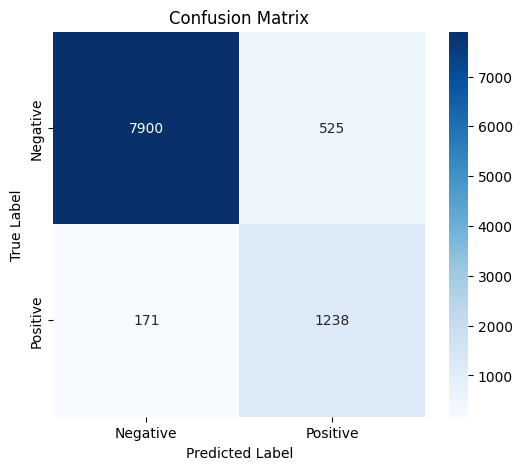

True Positives (TP): 1238
False Positives (FP): 525
True Negatives (TN): 7900
False Negatives (FN): 171


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute Confusion Matrix
cm = confusion_matrix(data_2023_labels,predictions)

# Print the matrix
print("Confusion Matrix:\n", cm)

# Plot the Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

from sklearn.metrics import confusion_matrix

# Compute Confusion Matrix
cm = confusion_matrix(data_2023_labels,predictions)

# Extract TP, TN, FP, FN
TN = cm[0, 0]  # True Negative
FP = cm[0, 1]  # False Positive
FN = cm[1, 0]  # False Negative
TP = cm[1, 1]  # True Positive

print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")


## LIME

In [ ]:
# LIME Integration
test_inputs_np = test_inputs.numpy()

# Feature names for all 48 columns
feature_names = ['Application Major', 'Scholarship_Awarded', 'Application CGPA', 'FAFSA Filed',
                 'High School Code', 'Financial Aid Appeal', 'Accepted Student Day Event Attended',
                 'Campus Visits - Person', 'Campus Visits - App', 'Logins Before Admit',
                 'Acceptance Call Success', 'Application Consider Test Scores', 'Application ACRK',
                 'Waitlist Confirmed Date', 'Emails Sent', 'Emails Opened', 'Was Inquiry', 'Athlete',
                 'Address 1 Region_Midwest', 'Address 1 Region_Northeast', 'Address 1 Region_South',
                 'Address 1 Region_Southwest', 'Address 1 Region_Territory', 'Address 1 Region_West',
                 'Application Housing_Commuter', 'Application Housing_Residential',
                 'Application Enroll Status_Full Time', 'Application Enroll Status_Part Time',
                 'Person Sex_F', 'Person Sex_M', 'High School Region_Midwest',
                 'High School Region_Northeast', 'High School Region_South',
                 'High School Region_Southwest', 'High School Region_Territory',
                 'High School Region_West', 'Application Span', 'Admission Span',
                 'Application College_00', 'Application College_CAS', 'Application College_COB',
                 'Application College_HCLC', 'Application College_ID', 'Application College_SHS',
                 'Application College_TCOE', 'Address 1 Region_Military',
                 'High School Region_Military', 'Person Sex_Unknown']

# Debug: Verify shapes
print(f"train_inputs shape: {train_inputs.shape}")
print(f"Number of feature names: {len(feature_names)}")

# Prediction function for LIME
def predict_proba(X):
    X_tensor = torch.from_numpy(X).float()
    save_net.eval()
    with torch.no_grad():
        outputs = save_net(X_tensor)
        probs = torch.softmax(outputs, dim=1).numpy()
    return probs

# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=train_inputs.numpy(),
    feature_names=feature_names,
    categorical_features=[0, 4],  # Application Major, High School Code
    class_names=['Not Admitted', 'Admitted'],
    mode='classification'
)

# Explain a test instance
instance_idx = 0
instance = test_inputs_np[instance_idx]
true_label = test_labels.numpy()[instance_idx]
print(f"\nExplaining prediction for instance {instance_idx} with true label: {true_label}")

exp = explainer.explain_instance(
    data_row=instance,
    predict_fn=predict_proba,
    num_features=10,  # Show top 10 features (out of 48)
    num_samples=5000
)

# Show explanation
print("LIME Explanation:")
exp.save_to_file('/content/log')
exp.save_to_file('lime_explanation.html')
print("Explanation saved to 'lime_explanation.html'.")

# Print feature contributions
print("Feature Contributions:")
for feature, weight in exp.as_list():
    print(f"{feature}: {weight:.4f}")

train_inputs shape: torch.Size([9618, 48])
Number of feature names: 48

Explaining prediction for instance 0 with true label: 0
LIME Explanation:
Explanation saved to 'lime_explanation.html'.
Feature Contributions:
Logins Before Admit <= 2.00: -0.2905
Person Sex_F <= 0.00: 0.1473
Address 1 Region_Northeast <= 0.00: 0.1305
High School Region_Southwest <= 0.00: 0.1278
Application College_HCLC <= 0.00: 0.1225
Application Span <= 0.00: 0.0898
High School Region_Northeast <= 0.00: 0.0892
Address 1 Region_Midwest <= 0.00: -0.0771
Campus Visits - App <= 0.00: 0.0665
Admission Span <= 0.00: 0.0524


In [ ]:
# Prediction function for LIME
def predict_proba(X):
    X_tensor = torch.from_numpy(X).float()
    my_model.eval()
    with torch.no_grad():
        outputs = my_model(X_tensor)
        probs = torch.softmax(outputs, dim=1).numpy()
    return probs

# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=train_inputs.numpy(),
    feature_names=feature_names,
    categorical_features=[0, 4],  # Application Major, High School Code
    class_names=['Not Admitted', 'Admitted'],
    mode='classification'
)

# Explain a test instance
instance_idx = 9
instance = test_inputs_np[instance_idx]
true_label = test_labels.numpy()[instance_idx]
print(f"\nExplaining prediction for instance {instance_idx} with true label: {true_label}")

exp = explainer.explain_instance(
    data_row=instance,
    predict_fn=predict_proba,
    num_features=10,
    num_samples=5000
)

# Show explanation
print("LIME Explanation:")
try:
    exp.show_in_notebook()  # Try to display inline, no extra args
except Exception as e:
    print(f"Failed to display in notebook: {e}")
exp.save_to_file('lime_explanation.html')
print("Explanation saved to 'lime_explanation.html'. Download from Colab's file explorer.")

# Print feature contributions
print("Feature Contributions:")
for feature, weight in exp.as_list():
    print(f"{feature}: {weight:.4f}")

NameError: name 'lime' is not defined

Interpreting Your Feature Contributions
Let’s assume the model predicted Admitted (1) for this instance. Here’s what each line means:

Logins Before Admit <= 2.00: -0.2998
Meaning: The fact that this student logged in 2 or fewer times before admission strongly decreases the probability of being Admitted.
Impact: This is the strongest negative contributor (-0.2998), suggesting that low login activity is a significant signal against admission in this local context.
Campus Visits - App <= 0.00: 0.1356
Meaning: Having zero campus visits recorded via the app increases the probability of Admitted.
Impact: A strong positive contributor (0.1356). This might seem counterintuitive (fewer visits leading to admission), but it reflects the model’s learned pattern for this instance—perhaps students with no app-recorded visits have other strong indicators.
Waitlist Confirmed Date <= 0.00: 0.1321
Meaning: A waitlist confirmation date of 0 (likely meaning not waitlisted or no date recorded) increases the probability of Admitted.
Impact: Positive contributor (0.1321). Not being waitlisted aligns with direct admission.
High School Region_Northeast <= 0.00: 0.1229
Meaning: The student’s high school not being in the Northeast (binary 0) increases the probability of Admitted.
Impact: Positive (0.1229). Suggests that coming from outside the Northeast is favorable here.
Address 1 Region_Territory <= 0.00: -0.0665
Meaning: The student’s address not being in a Territory (binary 0) decreases the probability of Admitted.
Impact: Negative (-0.0665). Indicates that not being from a Territory slightly works against admission.
Emails Opened > 23.00: -0.0424
Meaning: Opening more than 23 emails decreases the probability of Admitted.
Impact: Negative (-0.0424). High email engagement might signal something (e.g., uncertainty) that the model associates with non-admission.
Address 1 Region_Southwest <= 0.00: 0.0414
Meaning: Not being from the Southwest (binary 0) increases the probability of Admitted.
Impact: Positive (0.0414). Suggests a slight preference for students outside the Southwest.
Address 1 Region_West <= 0.00: -0.0372
Meaning: Not being from the West (binary 0) decreases the probability of Admitted.
Impact: Negative (-0.0372). Indicates a slight disadvantage for non-Western students.
Accepted Student Day Event Attended <= 0.00: -0.0298
Meaning: Not attending the Accepted Student Day event (0) decreases the probability of Admitted.
Impact: Negative (-0.0298). Non-attendance slightly hurts the prediction.
3.20 < Application CGPA <= 3.60: 0.0237
Meaning: Having a CGPA between 3.20 and 3.60 increases the probability of Admitted.
Impact: Positive (0.0237). A moderate CGPA in this range is a slight positive factor.